# Signs digits classifier
In this notebook I'll explain how to use pytorch for develop deep learning model than can recognize the signs digits (by your hand ) you can use this notebook on any data you want to classifier, I'll try to expalin as much as possiable to make it easy to use and understand 

In [1]:
# Import what we need
# matplotlib for showing our data
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib
# numpy and torch for create the model
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image

## Load the data

Here I'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can download the data from my github[here](https://github.com/AhmedKYoussef/Sign-Language-Digits-Dataset.git)
or if you clone or download the project you don't need to download the data. The dataset is split into three parts, trai,test and valid. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I'll use pre-trained network, you'll need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [2]:
# the dirictory of the datasets
data_dir = 'data/Dataset'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'
valid_dir = data_dir + '/valid'

In [0]:
# Define transforms for the training, testing and validation sets
# make some rotate and resize to let your model more smart and recognize the flipped and rotated images
train_transforms = transforms.Compose([transforms.RandomRotation(40),
                                       # make sure that sqaure 224*224 for deal with pretrained model
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                # normalize for reduce the value of color range 0-255 and make it small value for faster compute 
                                      transforms.Normalize([0.485, 0.456, 0.406] ,
                                                           [0.229, 0.224, 0.225] )
                                      ])


valid_transforms = transforms.Compose([
                                      transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406] , [0.229, 0.224, 0.225])
                                      ])

test_transforms = transforms.Compose([
                                      transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406] , [0.229, 0.224, 0.225])
                                      ])

# Load the datasets with ImageFolder
image_datasets= dict()
image_datasets['train'] = datasets.ImageFolder(train_dir, transform=train_transforms)
image_datasets['test'] = datasets.ImageFolder(test_dir, transform=test_transforms)
image_datasets['valid'] = datasets.ImageFolder(valid_dir, transform=valid_transforms)

# Using the image datasets and define the dataloaders
dataloaders = dict()
# the dataset then the batch size(you can't take all data and compute them at once you need some batches to make it easy)
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True)
# you need shuffle your data to let your model deal with different types at the same time 
dataloaders['valid'] = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=32, shuffle=True)
dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `names.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [15]:
import json

with open('data/names.json', 'r') as f:
    digit_names = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, I'll use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

### you should make your researches to chosse the best pretrained model you will use  

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (I'll use densent121)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We should be able to get the validation accuracy above 70% if you build everything right.

In [0]:
# #define the pretrained model and make sure pretrained = True
model = models.densenet121(pretrained= True)
# here you can see the layers of the model
model

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:01<00:00, 26698627.72it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

##  when you go down you 'll see (classifier) and the in_features it must be the same in our neural network

Linear(in_features=1024, out_features=1000, bias=True)

In [0]:
# freeze our feature parameters
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
    ('dropout1',nn.Dropout(0.3)),
    # define the inputs must be 1024 for densent121 model, and any number of nodes you want
    ('inputs',nn.Linear(1024,512)),
    # use the activation function
    ('relu1', nn.ReLU()),
    # the input here must be same the output of the first layer
    ('fc1',nn.Linear(512,256)),
    ('relu2', nn.ReLU()),
    # here the output 10 beacuse we need 10 classifier from 0-9
    ('fc2',nn.Linear(256,10)),
    # use the logsoft max to make it as probablitiy
    ('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier

In [0]:
# define the loss function that calculate the loss
criterion = nn.CrossEntropyLoss()
# and the optimzier that reduce the loss and make otimize or mode
# the learning rate must be small 0.001, 0.01, 0.003 etc
optimizer = optim.Adam(model.classifier.parameters(),lr=0.001)

## that is the most important part training model! make sure you have Graphic card that support CUDA if no use clone the project on google colab and change the notebook setting to GPU , without GPU it will take many hours to train

In [3]:
if torch.cuda.is_available() == True:
    print("Run the next cell")
else:
    print("use google colab or any cloud has GPU support CUDA (NIVIDA)")
 

use google colab or any cloud has GPU support CUDA (NIVIDA)


In [ ]:
epochs = 20 # how many steps we want  (feel free to change it) 
print_every = 5 # at one step there will be many validtion test so we'll print every 5 validtion test
train_on_gpu = torch.cuda.is_available()
steps = 0
# change to cuda
if train_on_gpu: # if True
  model.cuda() 
# move the model into GPU important to make sure all the model in the GPU, without check it may cause errors
#(some data on cpu and some on GPU)

for e in range(epochs):
    running_loss = 0 # define the train loss or running_loss
    for ii, (inputs, labels) in enumerate(dataloaders['train']):
        steps += 1 # it count the mini steps
        
        # make sure the data in GPU
        if train_on_gpu:
          inputs,labels = inputs.cuda(), labels.cuda()
        # make sure the grad zero it's not important in first step but at the end we'll have grad value and to make new test
        # you need to make sure the the grad is zero and every thing is clean
        optimizer.zero_grad()
        
        # Forward and backward passes
        # now we'll pass the data into our CNN neural network
        outputs = model.forward(inputs)
        # then calculate the loss (out mistakes)
        loss = criterion(outputs, labels)
        # go back and count it as otimizer step
        #(means learn from your mistakes and try again but don't make the same mistakes)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0: # every 5 mini_steps
            model.eval() # the model on the evaluate mode
            valid_loss = 0
            accuracy=0
            
            
            for ii, (inputs2,labels2) in enumerate(dataloaders['valid']):
                optimizer.zero_grad()
                
                inputs2, labels2 = inputs2.to('cuda:0') , labels2.to('cuda:0')
                model.to('cuda:0')
                # no grad make the compute fast (and in this step we don't need the grad)
                with torch.no_grad():    
                    # go forward with the data
                    outputs = model.forward(inputs2)
                    # calc the valid loss
                    valid_loss = criterion(outputs,labels2)
                    # use the exponential function to make sure the result is not negative (some math )
                    ps = torch.exp(outputs).data
                    # see how much the output is True
                    equality = (labels2.data == ps.max(1)[1])
                    # this we called accuracy
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
                    # now calc the valid and accuray after make some test on the valid data 
            valid_loss = valid_loss / len(dataloaders['valid'])
            accuracy = accuracy /len(dataloaders['valid'])
            
                    
            
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Validation Lost {:.4f}".format(valid_loss),
                   "Accuracy: {:.4f}".format(accuracy))
            # now we finish one big step (epoch)
            
            running_loss = 0 # make sure the running loss = 0 to work clean on the next epoch

## after train the data we'll see the accuracy if it more than 70% we are going right and maybe need some fixes (more images, scaling data, add more layers) if it less than 70% it means there is something wrong on your model or you can't print the accuracy right

In [0]:
correct = 0
total = 0
model.to('cuda:0')
# we need the grad only in train prat so we'll close it to compute fast
with torch.no_grad():
    # test the accuracy
  for data in dataloaders['test']:
      images, labels = data
      images, labels = images.to('cuda'), labels.to('cuda')
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
        # if the predicted output equal the labels or samples sum them until the loop ends  
      correct += (predicted == labels).sum().item()
# print how many correct divide by the total images we make test on it then multipy by 100 to get the percentage
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 85 %


## Save the checkpoint

Now that our network is trained, save the model so you can load it later for making predictions. Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now. we don't need to train again and wait couple of hours

In [0]:
# TODO: Save the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu
torch.save({
    'input_size': 224*224*3,
    'output_size': 102,
    'model_name':'vgg16',
    'class to idx': model.class_to_idx,
    'state_dict': model.state_dict(),
    'optim state_dict': optimizer.state_dict(),
    'model': model,
    'epochs': epochs,
    
}, 'init_result_signsDigit.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [10]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(path):
    # it's important to make the map_location = 'cpu' or it 'll cause error in devices without GPU
  checkpoint = torch.load(path,  map_location='cpu') 
  model = checkpoint['model']
  model.state_dict(checkpoint['state_dict'])
  return model

In [11]:
# now you can call our trained model
model = load_checkpoint('signsDigit85.pth')
print(model)

C:\Users\mesta\Anaconda3\lib\site-packages\torch\serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\mesta\Anaconda3\lib\site-packages\torch\serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\mesta\Anaconda3\lib\site-packages\torch\serialization.py:367: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attrib

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the digit of the sign
## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 


In [5]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    img = Image.open(image)
    
    test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406] , [0.229, 0.224, 0.225])
                                      ])
    tensor_img = test_transforms(img)
    
    return tensor_img

In [6]:
# you can load any image here but I'll load from test floder
img = (test_dir + '/5/IMG_4104.jpg')
img = process_image(img)
img.shape

torch.Size([3, 224, 224])

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

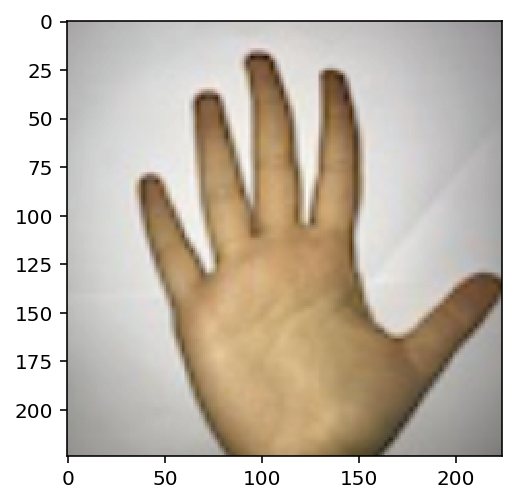

In [7]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
  
imshow(img)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

In [8]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    if torch.cuda.is_available():
      model.to('cuda:0')
    img = process_image(image_path)
    img = img.unsqueeze_(0)
    img = img.float()
    
    with torch.no_grad():
      if torch.cuda.is_available():
          output = model.forward(img.cuda())
      else:
        output = model.forward(img)
    probability = F.softmax(output.data,dim=1)
    
    return probability.topk(topk)

In [20]:
image_path = test_dir + '/8/IMG_1247.jpg'
probs, classes = predict(image_path, model)
print(probs)
print(classes)

tensor([[ 0.6170,  0.1957,  0.1731,  0.0091,  0.0031]])
tensor([[ 9,  7,  8,  4,  6]])


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5( optional maybe 1 or 2) classes as a bar graph, along with the input image. 

In [13]:
tr = dict()
model.class_to_idx
for i in model.class_to_idx:
  tr.setdefault(model.class_to_idx[i],i)

## it's the time of result note: maybe some output not True beacuse we need increase our model more than 90% to be more efficent 

In [16]:
x = classes.cpu()
x = x.numpy()

for i in x[0]:
  print(digit_names[tr[i]])

Five
Three
Four
Nine
Eight


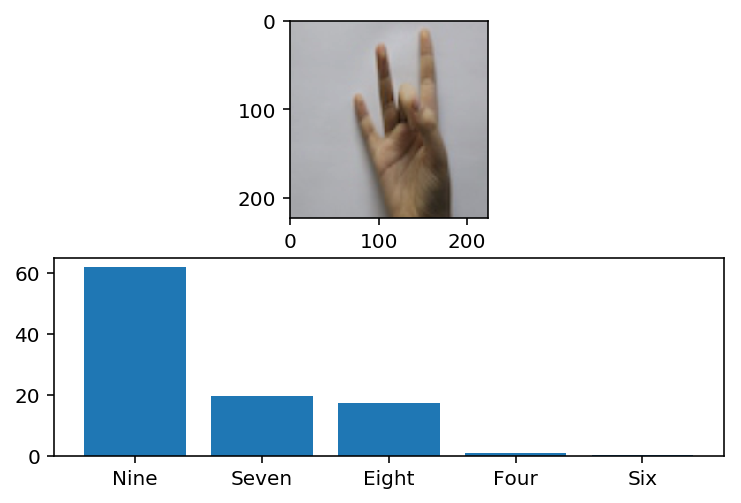

In [22]:
def Sanity_Checking(path_image):
  img = process_image(path_image)
  f = plt.figure()
  ax = f.add_subplot(211)
  imshow(img, ax=ax)
  plt.subplot(212)

  
  probs, classes = predict(path_image, model)
  x = classes.cpu()
  x = x.numpy()
  classes_name= [digit_names[tr[i]] for i in x[0]]
  probes = probs.cpu()
  probes = probes.numpy()
  probility =[prob*100 for prob in probes[0]]
  
  plt.bar(classes_name,probility)

  
Sanity_Checking(image_path)